# ДЗ №4

In [1]:
from google.colab import drive
drive.mount('/content/drive')

так как не влезало на Google Collab я подготовил тренировочные данные на своем google drive оставил только те картинки где был Person (получилось 64k из 118k) 

ниже происходит процесс скачки всего

In [2]:
import os

if not os.path.exists('data'):
  print('Creating data directory and download files')
  !mkdir -p data
  !cd data && wget http://images.cocodataset.org/zips/val2017.zip && unzip -q val2017.zip && rm val2017.zip
  !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip && unzip -q annotations_trainval2017.zip && rm annotations_trainval2017.zip

if not os.path.exists('cocoapi'):
  print('\n\nDownload and setup COCO API')
  !git clone https://github.com/cocodataset/cocoapi && cd cocoapi/PythonAPI && make

if not os.path.exists('me_256.png'):
  !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png

if not os.path.exists('data/train2017'):
  print('\n\nCopy prepared persons tar')
  !cp drive/My\ Drive/data/train2017.tar train2017.tar
  print('UNPACK TAR')
  !tar -xf train2017.tar

if not os.path.exists('best_model.hdf5'):
  print('\n\nCopy saved model')
  !cp drive/My\ Drive/data/best_model.hdf5 best_model.hdf5

Creating data directory and download files
--2020-06-09 17:13:41--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.81.72
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.81.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.9MB/s    in 49s     

2020-06-09 17:14:30 (16.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2020-06-09 17:14:37--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.76.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.76.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>]

In [0]:
%tensorflow_version 2.x

COCO_ROOT = './data/'

import imageio
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import sys
sys.path.insert(0, './cocoapi/PythonAPI')
from pycocotools.coco import COCO

### Модель U-NET

In [0]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

## Универсальный класс Dataset для сегментации

In [0]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        # dataset = dataset.repeat(1)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для загрузки картинок

In [0]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist, limit=None):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        if limit:
            self.img_list = self.img_list[:limit]
        
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        src = os.path.join(COCO_ROOT, img_fname)
        img = io.imread(src)

        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Обучаем модель

я сохранял промежуточные эпохи также к себе на Google Drive потому что часто отваливалось и приходилось начинать заново

In [7]:
TRAIN_LIMIT = None
COCO_dataset_train = COCO_Dataset('train', TRAIN_LIMIT) 
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=27.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


In [8]:
BATCH_SIZE = 20
NUM_EPOCHS = 10

train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, NUM_EPOCHS, 256)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, 256)

## Evaluate
model = build_model()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

if os.path.exists("best_model.hdf5"):
    model.load_weights("best_model.hdf5")

checkpoint = tf.keras.callbacks.ModelCheckpoint("drive/My Drive/data/best_model.hdf5", 
                                                monitor='val_accuracy', verbose=1, 
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='max') #save_freq = 100

hist = model.fit(train_ds, 
                 batch_size=BATCH_SIZE, 
                 epochs=NUM_EPOCHS,
                 validation_data=val_ds,
                 validation_steps=BATCH_SIZE,
                 callbacks=[checkpoint])

Epoch 1/10
3205/3205 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9067
Epoch 00001: val_accuracy improved from -inf to 0.90194, saving model to drive/My Drive/data/best_model.hdf5
3205/3205 [==============================] - 1856s 579ms/step - loss: 0.2203 - accuracy: 0.9067 - val_loss: 0.2289 - val_accuracy: 0.9019
Epoch 2/10
3205/3205 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9094
Epoch 00002: val_accuracy improved from 0.90194 to 0.91103, saving model to drive/My Drive/data/best_model.hdf5
3205/3205 [==============================] - 1855s 579ms/step - loss: 0.2149 - accuracy: 0.9094 - val_loss: 0.2082 - val_accuracy: 0.9110
Epoch 3/10
3205/3205 [==============================] - ETA: 0s - loss: 0.2098 - accuracy: 0.9119
Epoch 00003: val_accuracy did not improve from 0.91103
3205/3205 [==============================] - 1854s 578ms/step - loss: 0.2098 - accuracy: 0.9119 - val_loss: 0.2191 - val_accuracy: 0.9047
Epoch 4/10
3205/

### Проверим модель

In [0]:
def loadImage(name, inp_size=256):
    img = imageio.imread(name)
    img = img.astype(np.float32) / 255.

    shape = tf.shape(img)
    pad = (
        [0, tf.maximum(inp_size - shape[0], 0)],
        [0, tf.maximum(inp_size - shape[1], 0)],
        [0, 0],
    )
    img = tf.pad(img, pad)

    shape = tf.shape(img)
    ho = (shape[0] - inp_size) // 2
    wo = (shape[1] - inp_size) // 2
    img = img[ho:ho+inp_size, wo:wo+inp_size, :]

    return img

In [0]:
def showResult(model, name, th=0.4):
  img = loadImage(name)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
  ax1.imshow(img)

  out = model.predict(img[None, ...])[0, ...]
  ax2.imshow(out[...,0])

  a = out[...,0]
  a[a>=th] = 1
  a[a<th] = 0
  ax3.imshow(a)
  plt.show()  

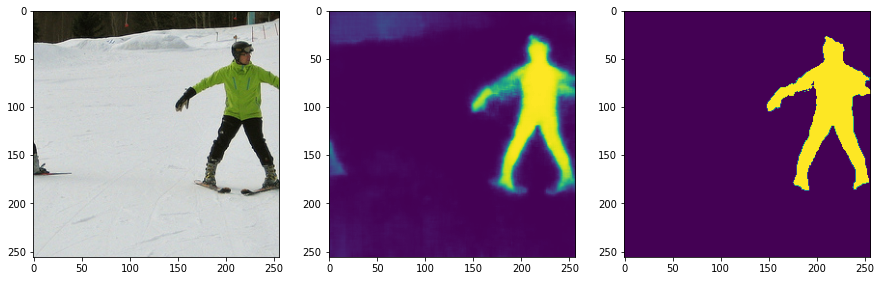

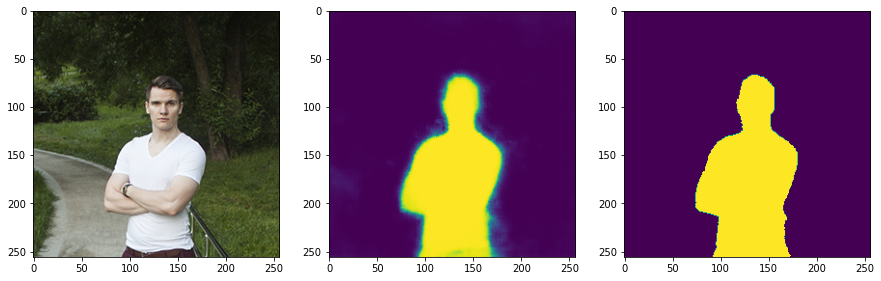

In [21]:
random = os.listdir('data/train2017')[np.random.randint(0,100)]

showResult(model, 'data/train2017/' + random, 0.5)
showResult(model, 'me_256.png', 0.5)